In [1]:
## BASED ON MILLER (2015) 
## DATA BASED ON CELL PHONE SWITCHING BETWEEN PLANS
## 

## ENSURE evaluate_classifier.py IS WITHIN THE SAME DIRECTORY

# Identifying Customer Targets (Python)

%matplotlib inline

# import packages for text processing and machine learning
import pandas as pd  # DataFrame structure and operations
import numpy as np  # arrays and numerical processing
import matplotlib.pyplot as plt  # 2D plotting
import statsmodels.api as sm  # logistic regression
import statsmodels.formula.api as smf  # R-like model specification
import patsy  # translate model specification into design matrices

import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING

# import user-defined module
import evaluate_classifier as eval


C:\Users\datab\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# OBTAIN data from text file in local directory

# read in comma-delimited text file and create data frame
# there are blank character fields for missing data
# read them as character fields initially
cell = pd.read_csv('CellSwitching.csv', sep = ',', header=0)
print(cell.head())

   age          job  marital  education default  balance rentown repairplan  \
0   30   unemployed  married    primary      no     1787    rent         no   
1   33     services  married  secondary      no     4789     own        yes   
2   35   management   single   tertiary      no     1350     own         no   
3   30   management  married   tertiary      no     1476     own        yes   
4   59  blue-collar  married  secondary      no        0     own         no   

    contact  plannum  months  devices poutcome  bresponse  
0  cellular       19      79        1  unknown          0  
1  cellular       11     220        5  failure          0  
2  cellular       16     185        2  failure          0  
3   unknown        3     199        1  unknown          0  
4   unknown        5     226        1  unknown          0  


In [3]:
# define jobtype variable
job_to_jobtype = {'admin.':'White Collar',\
    'entrepreneur':'White Collar',\
    'management':'White Collar',\
    'self-employed':'White Collar',\
    'blue-collar':'Blue Collar',\
    'services':'Blue Collar',\
    'technician':'Blue Collar'}
cell['jobtype'] = cell['job'].map(job_to_jobtype)
cell['jobtype'] = cell['jobtype'].fillna('Other/Unknown')

# set marital variable
marital_to_label = {'divorced':'Divorced',\
    'married':'Married',\
    'single':'Single'}
cell['marital'] = cell['marital'].map(marital_to_label)
cell['marital'] = cell['marital'].fillna('Unknown')

# set education variable
education_to_label = {'primary':'Primary',\
    'secondary':'Secondary',\
    'tertiary':'Tertiary'}
cell['education'] = cell['education'].map(education_to_label)
cell['education'] = cell['education'].fillna('Unknown')

# set no/yes variable labels
noyes_to_label = {'no':'No', 'yes':'Yes'}
cell['default'] = cell['default'].map(noyes_to_label)
cell['default'] = cell['default'].fillna('No')

# code response as binary variable
noyes_to_binary = {'No':0, 'Yes':1}
cell['repairplan'] = cell['repairplan'].map(noyes_to_binary)
cell['repairplan'] = cell['repairplan'].fillna('No')

# work only with cell clients who are being approached for the first time  
filter = cell['poutcome'].map(lambda d: d == "unknown")

# apply the filter and select columns needed for targeting model
cellwork = pd.DataFrame(cell[filter], columns = ['bresponse','age','jobtype',\
    'education', 'marital', 'default', 'balance', 'rentown', 'repairplan', 'months', 'devices'])
print(cellwork.head()) 
print(cellwork.shape)   


   bresponse  age        jobtype  education  marital default  balance rentown  \
0          0   30  Other/Unknown    Primary  Married      No     1787    rent   
3          0   30   White Collar   Tertiary  Married      No     1476     own   
4          0   59    Blue Collar  Secondary  Married      No        0     own   
7          0   39    Blue Collar  Secondary  Married      No      147     own   
8          0   41   White Collar   Tertiary  Married      No      221     own   

  repairplan  months  devices  
0         No      79        1  
3         No     199        1  
4         No     226        1  
7         No     151        1  
8         No      57        1  
(3705, 11)


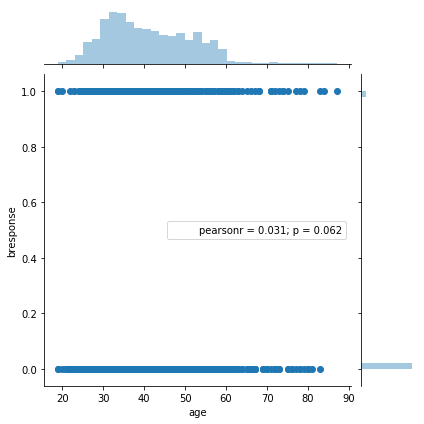

In [12]:
sns.jointplot(x="age", y="bresponse", data=cellwork)





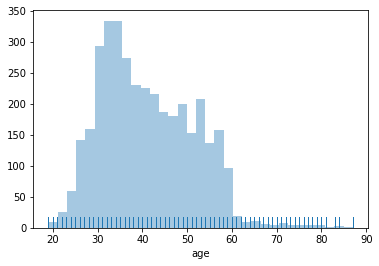

In [5]:
sns.distplot(cellwork['age'], kde=False, rug=True);


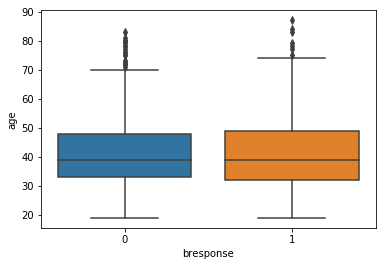

In [6]:
sns.boxplot(x="bresponse", y="age", data=cellwork)




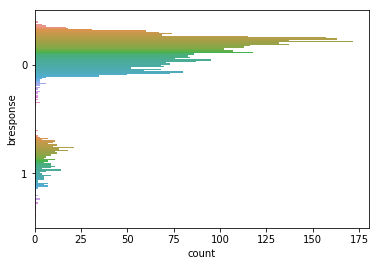

In [7]:
ax = sns.countplot(y="bresponse", data=cellwork,
             hue="age")

ax.legend_.remove()
# sns.xlabel=("Customer Count")
# sns.ylabel=("Customers who switch")
plt.show()

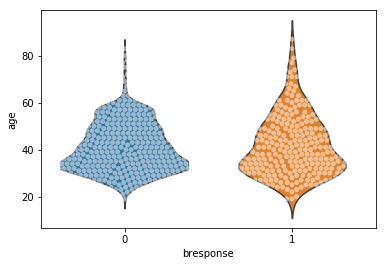

In [8]:
# MORE INTENSIVE PLOTS - SWARM & VIOLIN

#sns.swarmplot(x="bresponse", y="age", data=cellwork)
#sns.plt.show()

sns.violinplot(x="bresponse", y="age", data=cellwork, inner=None)
sns.swarmplot(x="bresponse", y="age", data=cellwork, color="w", alpha=.5)
plt.show()


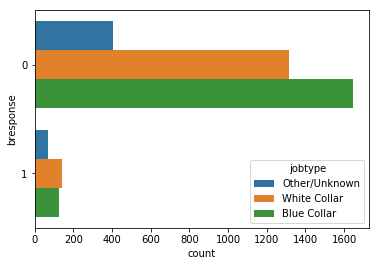

In [9]:
sns.countplot(y="bresponse", data=cellwork,
             hue="jobtype")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()



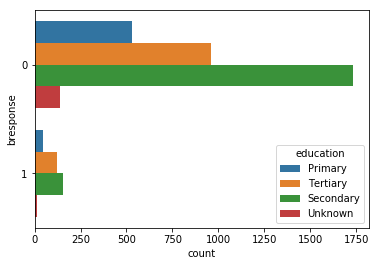

In [10]:
sns.countplot(y="bresponse", data=cellwork,
             hue="education")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()



## Another deviation between response ratios

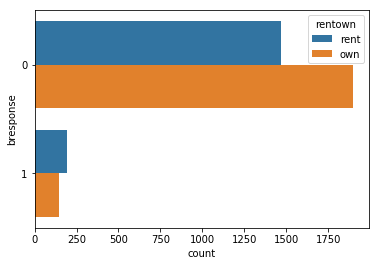

In [11]:
sns.countplot(y="bresponse", data=cellwork,
             hue="rentown")
sns.xlabel=("Customer Count")
sns.ylabel=("Customers who switch")
plt.show()

## End Model Review

## Start Code Review

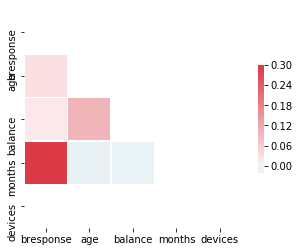

In [13]:
corr = cellwork.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

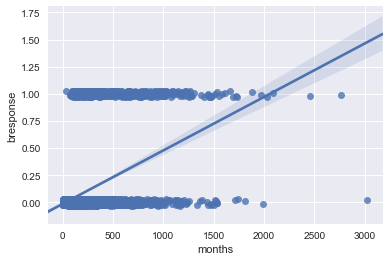

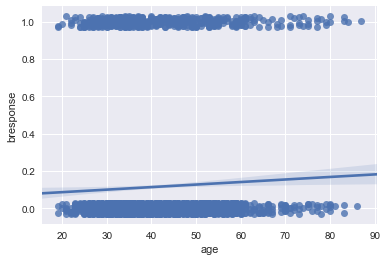

In [14]:
# QUICK SCATTER PLOT TO LOOK AT RELATIONSHIP BETWEEN VARIABLES

sns.set(color_codes=True)

sns.regplot(x="months", y="bresponse", data=cell, y_jitter=0.03)
plt.show()

sns.regplot(x="age", y="bresponse", data=cell, y_jitter=0.03)
plt.show()



In [15]:
# HOW MIGHT WE LOOK AT ACCOUNT BALANCE AND RESPONSE

# sns.regplot(x="balance", y="bresponse", data=cell, y_jitter=0.03)

# HOW MIGHT WE LOOK AT RENT/OWN VERSUS RESPONSE

# sns.regplot(x="rentown", y="bresponse", data=cell, y_jitter=0.03)
#plt.show()

In [16]:
print(cellwork.describe())
#print(cell['loan'])

print(cell.pivot_table(['age'], index = ['bresponse']))
print(cell.pivot_table(['devices'], index = ['bresponse']))
print(cell.pivot_table(['months'], index = ['bresponse']))
#print(cellwork.pivot_table(['repairplan'], index = ['bresponse']))
#print(cell.pivot_table(['rentown'], index = ['bresponse']))


         bresponse          age       balance       months  devices
count  3705.000000  3705.000000   3705.000000  3705.000000   3705.0
mean      0.090958    41.083671   1374.862078   262.103104      1.0
std       0.287588    10.373818   3008.524207   262.937329      0.0
min       0.000000    19.000000  -3313.000000     4.000000      1.0
25%       0.000000    33.000000     60.000000   102.000000      1.0
50%       0.000000    39.000000    415.000000   180.000000      1.0
75%       0.000000    49.000000   1412.000000   327.000000      1.0
max       1.000000    87.000000  71188.000000  3025.000000      1.0
                 age
bresponse           
0          40.998000
1          42.491363
            devices
bresponse          
0          1.471250
1          2.090211
               months
bresponse            
0          226.347500
1          552.742802


In [34]:

# examine descriptive statistics and frequency tables for variables in model
print(cellwork.describe())
print('\njobtype:\n',cellwork['jobtype'].value_counts())
print('\nmarital:\n',cellwork['marital'].value_counts())
print('\neducation:\n',cellwork['education'].value_counts())
print('\ndefault:\n',cellwork['default'].value_counts())
print('\nhousing:\n',cellwork['rentown'].value_counts())
#print('\nloan:\n',cellwork['loan'].value_counts())


         bresponse          age       balance       months  devices
count  3705.000000  3705.000000   3705.000000  3705.000000   3705.0
mean      0.090958    41.083671   1374.862078   262.103104      1.0
std       0.287588    10.373818   3008.524207   262.937329      0.0
min       0.000000    19.000000  -3313.000000     4.000000      1.0
25%       0.000000    33.000000     60.000000   102.000000      1.0
50%       0.000000    39.000000    415.000000   180.000000      1.0
75%       0.000000    49.000000   1412.000000   327.000000      1.0
max       1.000000    87.000000  71188.000000  3025.000000      1.0

jobtype:
 Blue Collar      1776
White Collar     1453
Other/Unknown     476
Name: jobtype, dtype: int64

marital:
 Married     2305
Single       957
Divorced     443
Name: marital, dtype: int64

education:
 Secondary    1891
Tertiary     1084
Primary       580
Unknown       150
Name: education, dtype: int64

default:
 No     3634
Yes      71
Name: default, dtype: int64

housing:
 own 

In [17]:

# examine means of continuous explanatory variables by response
print(cellwork.pivot_table(['age'], index = ['bresponse']))
print(cellwork.pivot_table(['balance'], index = ['bresponse']))


                 age
bresponse           
0          40.983076
1          42.089021
               balance
bresponse             
0          1359.654097
1          1526.851632


In [18]:
# baseline response rate computed (will be used later)
filter_took_offer = cellwork['bresponse'].map(lambda d: d == 1)
baseline_response_rate = len(cellwork[filter_took_offer]) / len(cellwork)
print('\nBaseline proportion of clients responding to offer: ',\
    round(baseline_response_rate,5), '\n')


Baseline proportion of clients responding to offer:  0.09096 



In [19]:

# examine proportion responding across levels 
# of categorical variables
print(cellwork.pivot_table(['bresponse'], index = ['jobtype']))
print(cellwork.pivot_table(['bresponse'], index = ['education']))
print(cellwork.pivot_table(['bresponse'], index = ['marital']))
print(cellwork.pivot_table(['bresponse'], index = ['default']))
print(cellwork.pivot_table(['bresponse'], index = ['rentown']))
#print(cellwork.pivot_table(['bresponse'], index = ['repairplan']))


               bresponse
jobtype                 
Blue Collar     0.072072
Other/Unknown   0.144958
White Collar    0.096352
           bresponse
education           
Primary     0.082759
Secondary   0.082496
Tertiary    0.112546
Unknown     0.073333
          bresponse
marital            
Divorced   0.126411
Married    0.073753
Single     0.115987
         bresponse
default           
No        0.090534
Yes       0.112676
         bresponse
rentown           
own       0.069995
rent      0.116727


## LOGIT MODEL FOR SWITCH

In [20]:
# specify model for logisitc regression
cell = 'bresponse ~ age + jobtype + education + marital +\
    default + balance + rentown'

# ----------------------------------
# fit logistic regression model 
# ----------------------------------
# convert R-like formula into design matrix needed for statsmodels        
y,x = patsy.dmatrices(cell, cellwork, return_type = 'dataframe')    

my_logit_model = sm.Logit(y,x)
# fit the model to the full data set
my_logit_model_fit = my_logit_model.fit()
print(my_logit_model_fit.summary())

# predicted probability of reponding to the offer
cellwork['pred_logit_prob'] = my_logit_model_fit.predict(linear = False)

Optimization terminated successfully.
         Current function value: 0.295795
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              bresponse   No. Observations:                 3705
Model:                          Logit   Df Residuals:                     3693
Method:                           MLE   Df Model:                           11
Date:                Wed, 25 Oct 2017   Pseudo R-squ.:                 0.02938
Time:                        09:08:06   Log-Likelihood:                -1095.9
converged:                       True   LL-Null:                       -1129.1
                                        LLR p-value:                 5.996e-10
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.9029      0.371     -7.815      0.000      -3.631

## End Code Review

In [43]:
# map target from probability cutoff specified
def prob_to_pred(x, cutoff):
    if(x > cutoff):
        return(1)
    else:
        return(0)

In [52]:
# try cutoff set at 0.50
#cellwork['pred_logit_50'] =\
#    cellwork['pred_logit_prob'].\
#    apply(lambda d: prob_to_pred(d, cutoff = 0.50))    
#print('\nConfusion matrix for 0.50 cutoff\n',\
#    pd.crosstab(cellwork.pred_logit_50, cellwork.bresponse, margins = True))    
# cutoff 0.50 does not work for targeting... all predictions 0 or No    


In [ ]:
# try cutoff set at 0.10
cellwork['pred_logit_10'] =\
    cellwork['pred_logit_prob'].\
    apply(lambda d: prob_to_pred(d, cutoff = 0.10))    
print('\nConfusion matrix for 0.10 cutoff\n',\
    pd.crosstab(cellwork.pred_logit_10, cellwork.response, margins = True)) 

print('\n Logistic Regression Performance (0.10 cutoff)\n',\
    'Percentage of Targets Correctly Classified:',\
    100 * round(eval.evaluate_classifier(cellwork['pred_logit_10'],\
    cellwork['response'])[4], 3),'\n')

In [51]:

# direct calculation of lift 
# decile labels from highest to lowest 
decile_label = []
for i in range(10):
    decile_label.append('Decile_'+str(10 - i))
# draws on baseline response rate computed earlier    
def lift(x):
    return(x / baseline_response_rate)

In [50]:

prediction_deciles = pd.qcut(cellwork.pred_logit_prob, 10, labels = decile_label)
decile_groups = cellwork.response.groupby(prediction_deciles)
print(decile_groups.mean())
lift_values = decile_groups.mean() / baseline_response_rate
print('\nLift Chart Values by Decile:\n', lift_values, '\n')

AttributeError: 'DataFrame' object has no attribute 'pred_logit_prob'

In [55]:
# apply the filter and select columns needed for targeting model
switchcell = pd.DataFrame(cell)

# columns=['bresponse','age','jobtype', 'education',
#                                        'marital', 'default', 'devices', 'balance', 'housing', 'loan']
print(cellwork.head()) 
print(cellwork.shape)   

ValueError: DataFrame constructor not properly called!